# Formanalyse: Hough-Transformation

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from skimage.transform import pyramid_gaussian, pyramid_expand
import skimage
from collections import defaultdict

## Akkumulator-Array mit Liniengleichung

### Aufgabe: Implementieren Sie Hough-Lines

In [9]:
# Akkumulator-Array
def hough_lines(edges):
    A = np.zeros(shape=(200,200))
    # iteriere über gefundene Kanten (> threshold)
    for edge in np.argwhere(edges > 0):
        # iteriere über alle möglichen "a"-Werte (= Steigung)
        for a in range(-100, 100):            
            b = int(edge[0] - a * edge[1])
            # A enthält folgende Achsen: 
            # a: -a_vals//2 .. a_vals//2
            # b: 0 .. b_vals
            # --> Mapping auf Array durch Addition von x_vals//2                        
            A[int(a * 100) + 100, int(b)] += 1
    return A, line_coeff

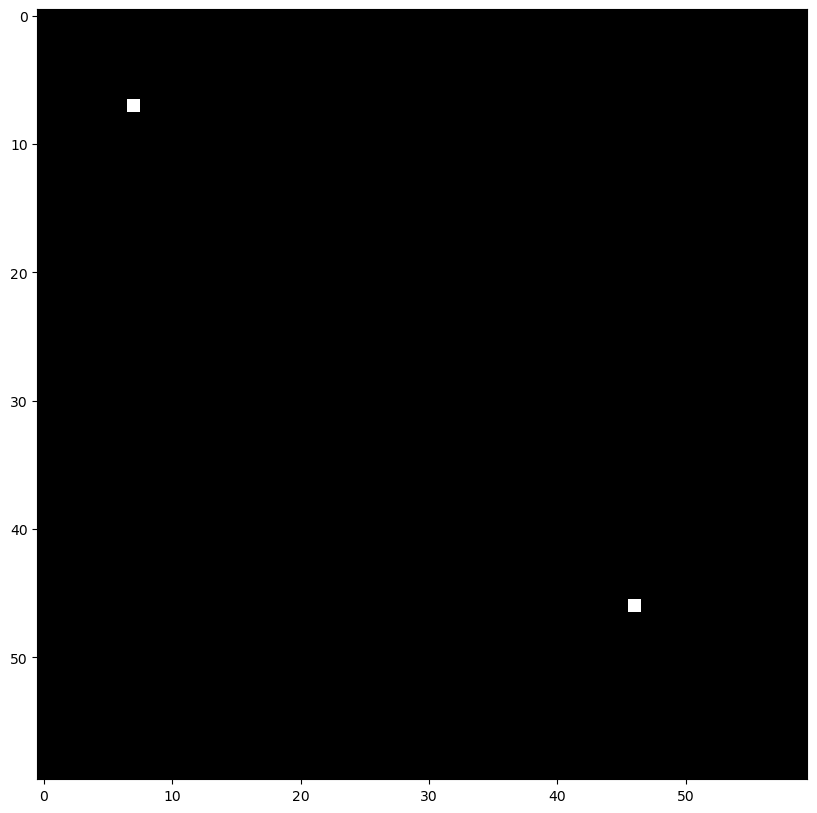

NameError: name 'A' is not defined

In [4]:
img = cv.imread('./img/hough_simple.bmp', cv.IMREAD_GRAYSCALE)
plt.figure(figsize=(20,10))
plt.imshow(img, cmap='gray')
plt.show()

A, line_coeff = hough_lines(img)
print('Maximum (', np.max(A), ') gefunden: ', line_coeff)

# Anwendung der Liniengleichung für Anzeige im Originalbild
out = np.zeros_like(img)
for x in range(img.shape[0]):
    for line in line_coeff:        
        y = int(line[1] * x + line[0])
        if (y >= 0) and (y < img.shape[1]):
            out[x,y] = 128

plt.figure()
plt.imshow(img, cmap='gray')
plt.imshow(out, cmap='inferno', alpha=0.5)
plt.show()

## Anwendung zur Linienerkennung

In [ ]:
# Laden des Bildes
img = cv.imread('./img/ex_lane.jpg', cv.IMREAD_GRAYSCALE)
plt.figure(figsize=(20,10))
plt.imshow(img, cmap='gray')
plt.show()

# Skalierung des Bildes
h,w = img.shape
ratio = 3
kernel_size = 3
low_threshold = 240
pyr_elem = 6

img_small = tuple(pyramid_gaussian(img, downscale=2))

plt.figure()
plt.title('Skaliertes Bild')
plt.imshow(skimage.img_as_ubyte(img_small[pyr_elem]), cmap='gray')
plt.show()

# Kantenerkennung
edges = cv.Canny(skimage.img_as_ubyte(img_small[pyr_elem]), low_threshold, low_threshold*ratio, kernel_size)
edges = edges.reshape([img_small[pyr_elem].shape[0], img_small[pyr_elem].shape[1]])

plt.figure()
plt.imshow(edges, cmap='gray', vmin=0, vmax=255)
plt.show()

# Anwendung der Hough-Transformation
A, line_coeff = hough_lines(edges)
print('Maximum (', np.max(A), ') gefunden: ', line_coeff)

# Anwendung der Liniengleichung für Anzeige im Originalbild
out = np.zeros_like(edges)
for x in range(edges.shape[0]):
    for line in line_coeff:        
        y = int(line[1] * x + line[0])
        if (y >= 0) and (y < edges.shape[1]):
            out[x,y] = 128


# Skalierung des Bildes
out_large = pyramid_expand(out, upscale=2**pyr_elem)

plt.figure()
plt.imshow(edges, cmap='gray')
plt.imshow(out, cmap='inferno', alpha=0.5)
plt.show()
plt.figure()
plt.imshow(img, cmap='gray')
plt.imshow(out_large, cmap='inferno', alpha=0.5)
plt.show()

## Akkumulator-Array mit Polar-Transformation 

In [ ]:
def hough_lines_polar(edges):    
    # akku, thetas, rhos = hough_lines_polar(edges)
    # akku: Akkumulator-Array (a -> theta, b -> rho)
    # thetas: -90° .. 90°
    # rhos: - sqrt(width^2 * height^2) .. sqrt(width^2 * height^2)


    width, height = edges.shape
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, 2*diag_len)

    A = np.zeros(shape=(2*diag_len, len(thetas)))

    # iteriere über gefundene Kanten (> threshold)
    for edge in np.argwhere(edges > 0):
        # iteriere über alle möglichen "a"-Werte (= Steigung)
        for k in range(len(thetas)):            
            rho = int(edge[0] * np.cos(thetas[k]) + edge[1] * np.sin(thetas[k]))            
            # A enthält folgende Achsen: 
            # a: -a_vals//2 .. a_vals//2
            # b: 0 .. b_vals
            # --> Mapping auf Array durch Addition von x_vals//2                        
            A[rho + diag_len, k] += 1

    plt.figure(figsize=(10,20))
    plt.title('Akkumulator-Array')
    plt.imshow(A, cmap='inferno')
    plt.xlabel('Theta (Winkel)')
    plt.xticks(np.arange(0, len(thetas), step=45), np.round(np.deg2rad(np.arange(-90.0, 90.0, step=45)),2))
    plt.ylabel('Rho (Distanz)')
    plt.yticks(np.arange(0, 2*diag_len, step=10), np.arange(-diag_len, diag_len, step=10))
    plt.show()    
    
    return A, thetas, rhos

In [ ]:
# Test der Implementierung mit einem Punkt
img = np.zeros((150,150))
img[75, 75] = 1
plt.figure(figsize=(20,10))
plt.imshow(img, cmap='gray')
plt.show()

A, thetas, rhos = hough_lines_polar(img)
line_coeff = np.argmax(A)
rho = int(rhos[int(line_coeff / A.shape[1])])
theta = thetas[int(line_coeff % A.shape[1])]
theta_deg = np.rad2deg(theta)
print('Maximum gefunden für rho=', rho, 'theta=', theta_deg, '.')
#print(len(line_coeff))

In [ ]:
# Test der Implementierung mit zwei Punkten
img = np.zeros((150,150))
img[75, 75] = 1
img[50, 50] = 1
plt.figure(figsize=(20,10))
plt.imshow(img, cmap='gray')
plt.show()

A, thetas, rhos = hough_lines_polar(img)
line_coeff = np.argmax(A)
rho = int(rhos[int(line_coeff / A.shape[1])])
theta = thetas[int(line_coeff % A.shape[1])]
theta_deg = np.rad2deg(theta)
print('Maximum gefunden für rho=', rho, 'theta=', theta_deg, '.')

# Anwendung der Liniengleichung für Anzeige im Originalbild
out = np.zeros_like(img)
for x in range(img.shape[0]):         
    y = int(-np.cos(theta) / np.sin(theta) * x + rho / np.sin(theta))
    if (y >= 0) and (y < img.shape[1]):
        out[x,y] = 128

plt.figure()
plt.title('Rekonstruiertes Bild')
plt.imshow(img, cmap='gray')
plt.imshow(out, cmap='inferno', alpha=0.5)

### Aufgabe: Circle Detection with Hough

In [ ]:
# Aufgabe: Implementieren Sie Hough Circles
def hough_circles(edges, r_min = 5, r_max = 50, r_delta = 5):    
    # akku, thetas, rhos = hough_circles(edges, rho_min, rho_max, rho_delta)    
    # thetas: 0° .. 360°
    # rhos: r_min .. r_max
  
    return A, thetas, rs

# Test der Implementierung mit einem Punkt
#img = np.zeros((150,150))
img = cv.imread('./img/hough_circle.jpg', cv.IMREAD_GRAYSCALE)
#img[75, 75] = 1
#img[100,100] = 1
plt.figure(figsize=(20,10))
plt.imshow(img, cmap='gray')
plt.show()

A, thetas, rs = hough_circles(img)

# durchsuche Accumulator-Array nach vielversprechenden Kandidaten (Voting > Threshold)
# Kandidaten werden hierzu nach Voting sortiert
bin_threshold = 0.75
out_circles = []
for candidate_circle, votes in sorted(A.items(), key=lambda i: -i[1]):
    x, y, r = candidate_circle
    current_vote_percentage = votes / len(thetas)
    if current_vote_percentage >= bin_threshold: 
        # mögliche Kandidaten werden in Liste aufgenommen
        out_circles.append((x, y, r, current_vote_percentage))
        print(x, y, r, current_vote_percentage)

out = np.zeros_like(img)
for x,y,r,v in out_circles:    
    out = cv.circle(out, (x,y), r, 255, 1)

plt.figure()
plt.imshow(out, cmap='gray'); plt.title('Resultat von Hough-Circles'); plt.show()

### Aufgabe: Nutzen Sie die OpenCV-Methode cv.HoughCircles zur Kreiserkennung

In [ ]:
# detect circles in the image with OpenCV


# Curve Fitting

In [ ]:
# Anscombes Quartett
x = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

## Linear Regression
In diesem Kapitel wird das Ergebnis einer eigenen linearen Regression mit der von NumPy verglichen.

In [ ]:
# Beispielanwendung auf Daten (x, y1)
# Aufgabe: implementieren Sie ein Polynomfitting für ein Polynom 1. Grades und vergleichen Sie es mit np.polyfit-Ergebnissen


# Aufgabe: Implementieren Sie das Bestimmtheitsmaß und vergleichen Sie so Ihre Regression


## Polynom-Fitting

In [ ]:
# Beispielanwendung auf Daten (x, y1)
w1_1, w1_0 = np.polyfit(x, y1, 1)                                       # wende Polynom-Fitting 1. Grades auf Datenreihe an
w2_2, w2_1, w2_0 = np.polyfit(x, y1, 2)                                 # wende Polynom-Fitting 2. Grades auf Datenreihe an
w3_3, w3_2, w3_1, w3_0 = np.polyfit(x, y1, 3)                           # wende Polynom-Fitting 3. Grades auf Datenreihe an
w4_7, w4_6, w4_5, w4_4, w4_3, w4_2, w4_1, w4_0 = np.polyfit(x, y1, 7)   # wende Polynom-Fitting 7. Grades auf Datenreihe an

# berechne x- und y-Koordinaten mit gefunedenen Parametern
xn = np.linspace(0, 20, 100)        # x-Koordinaten
x = np.array(x)
yn1 = w1_1 * xn + w1_0                                      # Polynom 1. Grades
yn2 = w2_2 * xn**2 + w2_1 * xn + w2_0                       # Polynom 2. Grades
yn3 = w3_3 * xn**3 + w3_2 * xn**2 + w3_1 * xn + w3_0        # Polynom 3. Grades
yn7 = w4_7 * xn**7 + w4_6 * xn**6 + w4_5 * xn**5 + w4_4 * xn**4 + w3_3 * xn**3 + w3_2 * xn**2 + w3_1 * xn + w3_0        # Polynom 7. Grades

plt.figure(figsize=(20,5))
plt.plot(x,y1,'ob',label='Daten'); 
plt.plot(xn,yn1,'-r',label='Polyn. 1. Grades'); 
plt.plot(xn,yn2,'-g',label='Polyn. 2. Grades'); 
plt.plot(xn,yn3,'-k',label='Polyn. 3. Grades');  
plt.plot(xn,yn3,'-c',label='Polyn. 7. Grades');  
plt.legend(); plt.show()

## Overfitting

In [ ]:
x = [2,3,4,5,6,7,8,9]
y1 = [8,7.8,8.5,9.8,10,8.5,10.5,10.3]

# Beispielanwendung auf Daten (x, y1)
w1_1, w1_0 = np.polyfit(x, y1, 1)                                       # wende Polynom-Fitting 1. Grades auf Datenreihe an
w = np.polyfit(x, y1, 6)   # wende Polynom-Fitting 7. Grades auf Datenreihe an

# berechne x- und y-Koordinaten mit gefunedenen Parametern
xn = np.linspace(0, 10, 100)        # x-Koordinaten
x = np.array(x)
yn1 = w1_1 * xn + w1_0              # Polynom 1. Grades
yn = np.poly1d(w)                   # Polynom 6. Grades

plt.figure(figsize=(20,5))
plt.plot(x,y1,'ob',label='Daten'); 
plt.plot(xn,yn1,'-r',label='Polyn. 1. Grades'); 
plt.plot(xn,yn(xn),'-c',label='Polyn. 6. Grades');  
plt.ylim(0,15)
plt.legend(); plt.show()

## Aufgabe: Ermitteln Sie die Funktion in der Abbildung

In [ ]:
x_n = [-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19]

y_n = [-36823, -31428, -26587, -22270, -18447, -15088, -12163,  -9642,  -7495,  -5692,
  -4203,  -2998,  -2047,  -1320,   -787,   -418,   -183,    -52,      5,     18,
     17,     32,     93,    230,    473,    852,   1397,   2138,   3105,   4328,
   5837,   7662,   9833,  12380,  15333,  18722,  22577,  26928,  31805,  37238]

   

# Anscombes Quartett


In [ ]:
datasets = {
    'I': (x, y1),
    'II': (x, y2),
    'III': (x, y3),
    'IV': (x4, y4)
}

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6),
                        gridspec_kw={'wspace': 0.08, 'hspace': 0.08})
axs[0, 0].set(xlim=(0, 20), ylim=(2, 14))
axs[0, 0].set(xticks=(0, 10, 20), yticks=(4, 8, 12))

# iteriere über Datensätze und Plot-Quadranten
for ax, (label, (x, y)) in zip(axs.flat, datasets.items()):
    ax.text(0.1, 0.9, label, fontsize=20, transform=ax.transAxes, va='top')
    ax.tick_params(direction='in', top=True, right=True)
    ax.plot(x, y, 'o')

    # linear regression
    w1, w0 = np.polyfit(x, y, deg=1)  # slope, intercept
    ax.axline(xy1=(0, w0), slope=w1, color='r', lw=2)

    # add text box for the statistics
    stats = (f'$\\mu$ = {np.mean(y):.2f}\n'
             f'$\\sigma$ = {np.std(y):.2f}\n'
             f'$r$ = {np.corrcoef(x, y)[0][1]:.2f}')
    bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
    ax.text(0.95, 0.07, stats, fontsize=9, bbox=bbox,
            transform=ax.transAxes, horizontalalignment='right')
